[OK] Saved signals → level45_adaptive_lookback_signals.csv
[OK] Saved grid    → level45_adaptive_lookback_grid.csv
[OK] Saved summary → level45_adaptive_lookback_summary.json
Selected lookback L* = 10
Strategy CAGR: 0.00%, Sharpe: 0.00
Buy&Hold  CAGR: 13.92%, Sharpe: 0.84


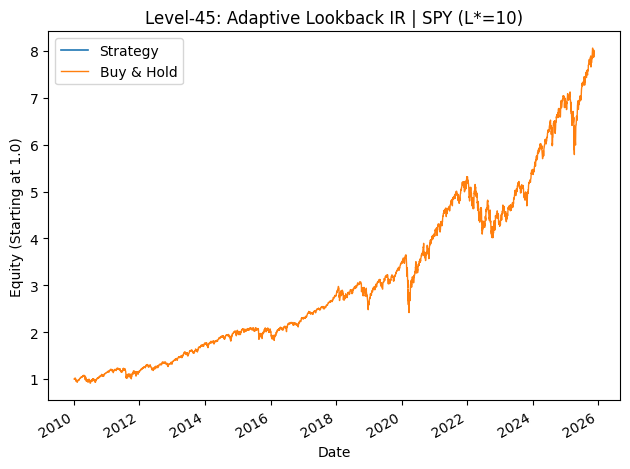

In [3]:
# level45_adaptive_lookback_ir.py
# Level-45: Adaptive lookback via Information Ratio maximization.
# - Single-asset time-series momentum
# - Grid search over lookback windows
# - Time-aware K-fold IR on train, plus test IR
# - TC-aware backtest
#
# Example:
#   python level45_adaptive_lookback_ir.py --symbol SPY --lookbacks 10 20 60 120 252
#   python level45_adaptive_lookback_ir.py --symbol QQQ --tc-bps 5 --train-frac 0.8

import os
import json
import argparse
from dataclasses import dataclass, asdict
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


# ----------------------------- Config -----------------------------
@dataclass
class Config:
    symbol: str = "SPY"
    start: str = "2010-01-01"
    lookbacks: List[int] = None
    tc_bps: float = 10.0
    train_frac: float = 0.7
    n_folds: int = 4
    out_signals_csv: str = "level45_adaptive_lookback_signals.csv"
    out_grid_csv: str = "level45_adaptive_lookback_grid.csv"
    out_json: str = "level45_adaptive_lookback_summary.json"


# ----------------------------- Data Loader -----------------------------
def load_data(cfg: Config) -> pd.DataFrame:
    df = yf.download(cfg.symbol, start=cfg.start, auto_adjust=True, progress=False)
    if df.empty:
        raise RuntimeError("No data downloaded. Check symbol/start date/internet.")
    df = df[["Close"]].rename(columns={"Close": "close"})
    df["ret"] = df["close"].pct_change().fillna(0.0)
    return df.dropna()


# ----------------------------- Helpers -----------------------------
def _ensure_series(returns, index: Optional[pd.Index] = None) -> pd.Series:
    """
    Coerce 'returns' to a 1D Series.

    - Handles Series, DataFrame (takes first column), numpy arrays (flattens if 2D),
      and generic iterables.
    - If index is provided, it is forced onto the Series; otherwise default index.
    """
    if returns is None:
        return pd.Series(dtype=float)

    if isinstance(returns, pd.Series):
        s = returns.copy()
    elif isinstance(returns, pd.DataFrame):
        if returns.shape[1] == 0:
            s = pd.Series(dtype=float)
        else:
            s = returns.iloc[:, 0].copy()
    else:
        arr = np.asarray(returns)
        if arr.ndim > 1:
            arr = arr.reshape(-1)
        s = pd.Series(arr)

    s = s.dropna()
    if index is not None:
        # Align/force index length if needed
        if len(s) == len(index):
            s.index = index
        else:
            # Reindex with fill if mismatch; better than raising for now
            s = s.reindex(index).astype(float)
    return s


def information_ratio(returns, ann_factor: int = 252) -> float:
    """Annualized IR (Sharpe) for a stream of daily returns."""
    r = _ensure_series(returns).dropna()
    if len(r) < 2:
        return 0.0
    mu = float(r.mean())
    sigma = float(r.std())
    if sigma <= 0.0:
        return 0.0
    return float(mu / sigma * np.sqrt(ann_factor))


def kpi_summary(returns, ann_factor: int = 252) -> Dict[str, float]:
    """Return CAGR, Sharpe, Max Drawdown for a daily return series."""
    r = _ensure_series(returns).dropna()
    if len(r) < 2:
        return {"cagr": 0.0, "sharpe": 0.0, "maxdd": 0.0}

    equity = (1.0 + r).cumprod()
    n = len(equity)
    if n <= 1:
        cagr = 0.0
    else:
        cagr = float(equity.iloc[-1] ** (ann_factor / n) - 1.0)

    sharpe = information_ratio(r, ann_factor=ann_factor)
    dd = equity / equity.cummax() - 1.0
    maxdd = float(dd.min()) if len(dd) else 0.0
    return {"cagr": cagr, "sharpe": sharpe, "maxdd": maxdd}


def time_fold_ir(returns, n_folds: int = 4, ann_factor: int = 252) -> float:
    """
    Simple time-aware K-fold IR:
    - Split returns into contiguous folds in time
    - Compute IR per fold
    - Return average IR
    """
    r = _ensure_series(returns).dropna()
    n = len(r)
    if n < n_folds * 20:  # too short; just use global IR
        return information_ratio(r, ann_factor=ann_factor)

    fold_len = n // n_folds
    irs = []
    for k in range(n_folds):
        start = k * fold_len
        end = n if k == n_folds - 1 else (k + 1) * fold_len
        seg = r.iloc[start:end]
        if len(seg) < 5:
            continue
        ir_k = information_ratio(seg, ann_factor=ann_factor)
        irs.append(ir_k)
    if not irs:
        return information_ratio(r, ann_factor=ann_factor)
    return float(np.mean(irs))


# ----------------------------- Strategy Engine -----------------------------
def build_strategy_returns(df: pd.DataFrame, lookback: int, cfg: Config) -> Tuple[pd.Series, pd.Series]:
    """
    Time-series momentum:
      - Compute L-day momentum
      - signal_t = sign(momentum_t)
      - strategy_ret_t = signal_{t-1} * ret_t - TC_t
    """
    mom = df["close"].pct_change(lookback)
    signal = np.sign(mom)
    # Treat zeros and NaNs as flat
    signal = signal.replace(0, 0).fillna(0.0)
    signal = signal.ffill().fillna(0.0)

    flip = signal.diff().abs().fillna(0.0)
    tc = flip * (cfg.tc_bps * 1e-4)

    strat_ret = signal.shift(1).fillna(0.0) * df["ret"] - tc
    strat_ret.name = f"strat_L{lookback}"
    return strat_ret, signal


# ----------------------------- Tuning Engine -----------------------------
def tune_lookback(df: pd.DataFrame, cfg: Config) -> Tuple[int, pd.DataFrame]:
    """
    For each lookback in cfg.lookbacks:
      - Build strategy returns
      - Compute train IR, CV-IR, test IR + KPIs
    Returns best lookback (by CV-IR) and the full grid DataFrame.
    """
    n = len(df)
    split_idx = int(n * cfg.train_frac)
    if split_idx <= 0 or split_idx >= n:
        raise ValueError("train_frac leads to empty train/test split.")

    grid_rows = []

    for L in cfg.lookbacks:
        strat_ret, _ = build_strategy_returns(df, L, cfg)

        train_ret = strat_ret.iloc[:split_idx]
        test_ret = strat_ret.iloc[split_idx:]

        ir_train = information_ratio(train_ret)
        ir_cv = time_fold_ir(train_ret, n_folds=cfg.n_folds)
        ir_test = information_ratio(test_ret) if len(test_ret) > 10 else np.nan

        train_kpi = kpi_summary(train_ret)
        test_kpi = kpi_summary(test_ret) if len(test_ret) > 10 else {
            "cagr": np.nan, "sharpe": np.nan, "maxdd": np.nan
        }

        grid_rows.append({
            "lookback": L,
            "ir_train": ir_train,
            "ir_cv": ir_cv,
            "ir_test": ir_test,
            "cagr_train": train_kpi["cagr"],
            "sharpe_train": train_kpi["sharpe"],
            "maxdd_train": train_kpi["maxdd"],
            "cagr_test": test_kpi["cagr"],
            "sharpe_test": test_kpi["sharpe"],
            "maxdd_test": test_kpi["maxdd"]
        })

    grid = pd.DataFrame(grid_rows).set_index("lookback").sort_index()
    best_L = int(grid["ir_cv"].idxmax())
    return best_L, grid


# ----------------------------- Outputs -----------------------------
def save_outputs(
    df_signals: pd.DataFrame,
    grid: pd.DataFrame,
    cfg: Config,
    best_L: int,
    strat_ret,
    bh_ret
):
    # Ensure output directories exist
    os.makedirs(os.path.dirname(cfg.out_signals_csv) or ".", exist_ok=True)
    os.makedirs(os.path.dirname(cfg.out_grid_csv) or ".", exist_ok=True)
    os.makedirs(os.path.dirname(cfg.out_json) or ".", exist_ok=True)

    df_signals.to_csv(cfg.out_signals_csv, index=True, date_format="%Y-%m-%d")
    grid.to_csv(cfg.out_grid_csv, index=True)

    # Global KPIs
    strat_kpi = kpi_summary(strat_ret)
    bh_kpi = kpi_summary(bh_ret)

    summary = {
        "config": asdict(cfg),
        "best_lookback": best_L,
        "grid_top": grid.sort_values("ir_cv", ascending=False).head(5).to_dict(orient="index"),
        "strategy_kpi": strat_kpi,
        "buyhold_kpi": bh_kpi
    }

    with open(cfg.out_json, "w") as f:
        json.dump(summary, f, indent=2)

    print(f"[OK] Saved signals → {cfg.out_signals_csv}")
    print(f"[OK] Saved grid    → {cfg.out_grid_csv}")
    print(f"[OK] Saved summary → {cfg.out_json}")
    print(f"Selected lookback L* = {best_L}")
    print(f"Strategy CAGR: {strat_kpi['cagr']:.2%}, Sharpe: {strat_kpi['sharpe']:.2f}")
    print(f"Buy&Hold  CAGR: {bh_kpi['cagr']:.2%}, Sharpe: {bh_kpi['sharpe']:.2f}")


# ----------------------------- CLI -----------------------------
def parse_args() -> Config:
    p = argparse.ArgumentParser(
        description="Level-45: Adaptive lookback selection via Information Ratio maximization."
    )
    p.add_argument("--symbol", type=str, default="SPY")
    p.add_argument("--start", type=str, default="2010-01-01")
    p.add_argument(
        "--lookbacks", type=int, nargs="+",
        default=[10, 20, 60, 120, 252],
        help="List of candidate lookback windows (in trading days)."
    )
    p.add_argument("--tc-bps", type=float, default=10.0,
                   help="Round-trip transaction cost in basis points.")
    p.add_argument("--train-frac", type=float, default=0.7,
                   help="Fraction of data used for training / tuning.")
    p.add_argument("--n-folds", type=int, default=4,
                   help="Number of contiguous folds for time-aware CV on train set.")
    p.add_argument("--signals-csv", type=str,
                   default="level45_adaptive_lookback_signals.csv")
    p.add_argument("--grid-csv", type=str,
                   default="level45_adaptive_lookback_grid.csv")
    p.add_argument("--json", type=str,
                   default="level45_adaptive_lookback_summary.json")

    a = p.parse_args()
    return Config(
        symbol=a.symbol,
        start=a.start,
        lookbacks=a.lookbacks,
        tc_bps=a.tc_bps,
        train_frac=a.train_frac,
        n_folds=a.n_folds,
        out_signals_csv=a.signals_csv,
        out_grid_csv=a.grid_csv,
        out_json=a.json
    )


# ----------------------------- Main -----------------------------
def main():
    cfg = parse_args()
    df = load_data(cfg)

    # Tune lookback
    best_L, grid = tune_lookback(df, cfg)

    # Build final strategy using best lookback
    strat_ret_raw, signal_raw = build_strategy_returns(df, best_L, cfg)

    # Force everything to 1D Series with the same index
    idx = df.index
    strat_ret = _ensure_series(strat_ret_raw, index=idx)
    signal = _ensure_series(signal_raw, index=idx)

    equity_strat = (1.0 + strat_ret).cumprod()

    bh_ret = df["ret"]
    equity_bh = (1.0 + bh_ret).cumprod()

    # Build output DF with consistent index
    out = pd.DataFrame(index=idx)
    out["close"] = df["close"]
    out["ret"] = df["ret"]
    out[f"signal_L{best_L}"] = signal
    out[f"strat_ret_L{best_L}"] = strat_ret
    out["equity_strat"] = equity_strat
    out["equity_buyhold"] = equity_bh

    save_outputs(out, grid, cfg, best_L, strat_ret, bh_ret)

    # Plot equity curves
    equity_strat.plot(label="Strategy", linewidth=1.2)
    equity_bh.plot(label="Buy & Hold", linewidth=1.0)
    plt.title(f"Level-45: Adaptive Lookback IR | {cfg.symbol} (L*={best_L})")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Equity (Starting at 1.0)")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # Jupyter / IPython shim: strip kernel args like "-f kernel-xxxx.json"
    import sys
    sys.argv = [sys.argv[0]] + [
        arg for arg in sys.argv[1:]
        if arg != "-f" and not (arg.endswith(".json") and "kernel" in arg)
    ]
    main()
